# Classification on cities and test with different form of sentances

## Load layers

### Function

In [ ]:
import pandas as pd

def load_nth_layer_data(nth, dataset='cities', model='gemma-2b-it', template=False):
    if template :
        model = model + "_template"
    data_path = f'../data/activations/{dataset}/{model}_layer_{nth}_output.csv'
    data = pd.read_csv(data_path, header=None, dtype=str)

    # If data has column names, we drop them
    if 'neuron' in str(data.iloc[0, 0]):
        # print('Dropping column names')
        data = data.iloc[1:]

    nb_neurons_by_layer = data.shape[1] - 1
    columns = [f'neuron_{nth*nb_neurons_by_layer + i}' for i in range(nb_neurons_by_layer)] + ['label']
    data.columns = columns

    # Convert activation values to float and labels to int
    data = data.astype(float)
    data['label'] = data['label'].astype(int)

    # Add column corresponding to the dataset name
    data['dataset'] = dataset

    return data


### Settings

In [64]:
model1 ="Qwen1.5-0.5B"
model2 = "Qwen1.5-0.5B_chat"
dataset = "cities"
new_dataset = "cities_new"
counterfact_dataset = "counterfact_true_false_cities"
augm_dataset = "cities_augm"
datasets = [dataset, new_dataset, counterfact_dataset, augm_dataset]
layer = 12

model1_acts = [load_nth_layer_data(layer, dataset=data, model=model1) for data in datasets]
model2_acts = [load_nth_layer_data(layer, dataset=data, model=model2) for data in datasets]
model3_acts = [load_nth_layer_data(layer, dataset=data, model=model2, template=True) for data in datasets]

print('The column before the last one contains the labels (1 for true, 0 for false)')
print("The last column contains the dataset name")

The column before the last one contains the labels (1 for true, 0 for false)
The last column contains the dataset name


## Train and test the RandomForest

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_and_test(datasets1, datasets2, datasets3):
    
    df = pd.DataFrame(columns=['train','test', 'Qwen', 'Qwen-chat', 'Qwen-chat with template'])
    for i, (data1, data2, data3) in enumerate(zip(datasets1, datasets2, datasets3)):
        data1_shuffled = data1.sample(frac=1).reset_index(drop=True)
        data2_shuffled = data2.sample(frac=1).reset_index(drop=True)
        data3_shuffled = data3.sample(frac=1).reset_index(drop=True)
        X_train1, y_train1 = data1_shuffled.iloc[:, :-2], data1_shuffled.iloc[:, -2]
        X_train2, y_train2 = data2_shuffled.iloc[:, :-2], data2_shuffled.iloc[:, -2]
        X_train3, y_train3 = data3_shuffled.iloc[:, :-2], data3_shuffled.iloc[:, -2]
        clf1 = RandomForestClassifier(n_estimators=100, random_state=0)
        clf1.fit(X_train1, y_train1)
        clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
        clf2.fit(X_train2, y_train2)
        clf3 = RandomForestClassifier(n_estimators=100, random_state=0)
        clf3.fit(X_train3, y_train3)       
        for (data_test1,data_test2,data_test3) in zip(datasets1,datasets2,datasets3):
            data_test1_shuffled = data_test1.sample(frac=1).reset_index(drop=True)
            data_test2_shuffled = data_test2.sample(frac=1).reset_index(drop=True)
            data_test3_shuffled = data_test3.sample(frac=1).reset_index(drop=True)
            X_test1, y_test1 = data_test1_shuffled.iloc[:, :-2], data_test1_shuffled.iloc[:, -2]
            X_test2, y_test2 = data_test2_shuffled.iloc[:, :-2], data_test2_shuffled.iloc[:, -2]
            X_test3, y_test3 = data_test3_shuffled.iloc[:, :-2], data_test3_shuffled.iloc[:, -2]
            y_pred1 = clf1.predict(X_test1)
            y_pred2 = clf2.predict(X_test2)
            y_pred3 = clf3.predict(X_test3)
            acc1 = accuracy_score(y_test1, y_pred1)
            acc2 = accuracy_score(y_test2, y_pred2)
            acc3 = accuracy_score(y_test3, y_pred3)
            df.loc[len(df)] = [data1.iloc[0,-1],data_test1.iloc[0, -1], acc1, acc2, acc3]
    return df


df = train_and_test(model1_acts, model2_acts, model3_acts)
df

,train,test,Qwen,Qwen-chat,Qwen-chat with template
0,cities,cities,1.000000,1.000000,1.000000
1,cities,cities_new,0.661765,0.594920,0.667781
2,cities,counterfact_true_false_cities,0.616935,0.578629,0.647177
3,cities,cities_augm,0.701872,0.652406,0.710561
4,cities_new,cities,0.768048,0.632353,0.812166
5,cities_new,cities_new,1.000000,1.000000,1.000000
6,cities_new,counterfact_true_false_cities,0.623387,0.559677,0.636694
7,cities_new,cities_augm,0.693182,0.611631,0.705882
8,counterfact_true_false_cities,cities,0.897059,0.875668,0.896390
9,counterfact_true_false_cities,cities_new,0.776738,0.714572,0.781417


## For each dataset, train on activations obtained with default Qwen/finetuned Qwen and test on finetuned Qwen/default Qwen

In [68]:
model1 ="Qwen1.5-0.5B"
model2 = "Qwen1.5-0.5B_chat"
dataset = "cities"
new_dataset = "cities_new"
counterfact_dataset = "counterfact_true_false_cities"
augm_dataset = "cities_augm"
datasets = [dataset,new_dataset,counterfact_dataset, augm_dataset]
layer = 12


In [78]:
def train_and_test(train_datasets,test_datasets):
    importances = []
    df = pd.DataFrame(columns=['dataset', 'train on', 'test on', 'acc'])
    for test_data,train_data in zip(test_datasets,train_datasets):
        train_data_shuffled = train_data.sample(frac=1).reset_index(drop=True)
        X_train, y_train = train_data_shuffled.iloc[:, :-3], train_data_shuffled.iloc[:, -3]
        clf = RandomForestClassifier(n_estimators=100,random_state=0)
        clf.fit(X_train, y_train)
        importance  = clf.feature_importances_
        importance = importance / importance.max()
        nb_activations_by_layer = train_data.shape[1] - 3
        importance = importance.reshape(1, nb_activations_by_layer)
        importances.append(importance)
        X_test, y_test = test_data.iloc[:, :-3], test_data.iloc[:, -3]
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        df.loc[len(df)]= {'dataset': test_data.iloc[0, -2], 'train on': train_data.iloc[0, -1], 'test on': test_data.iloc[0, -1], 'acc': acc}

    return df,importances

datasets_model1 = [load_nth_layer_data(layer, data, model1) for data in datasets]
datasets_model2 = [load_nth_layer_data(layer, data, model2,template=True) for data in datasets]

for data in datasets_model1:
    data['model'] = model1
for data in datasets_model2:
    data['model'] = model2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

train_datasets = datasets_model1 + datasets_model2
test_datasets = datasets_model2 + datasets_model1
df, importances = train_and_test(train_datasets,test_datasets)
df


,dataset,train on,test on,acc
0,cities,Qwen1.5-0.5B,Qwen1.5-0.5B_chat,1.0
1,cities_new,Qwen1.5-0.5B,Qwen1.5-0.5B_chat,1.0
2,counterfact_true_false_cities,Qwen1.5-0.5B,Qwen1.5-0.5B_chat,1.0
3,cities_augm,Qwen1.5-0.5B,Qwen1.5-0.5B_chat,1.0
4,cities,Qwen1.5-0.5B_chat,Qwen1.5-0.5B,1.0
5,cities_new,Qwen1.5-0.5B_chat,Qwen1.5-0.5B,1.0
6,counterfact_true_false_cities,Qwen1.5-0.5B_chat,Qwen1.5-0.5B,1.0
7,cities_augm,Qwen1.5-0.5B_chat,Qwen1.5-0.5B,1.0


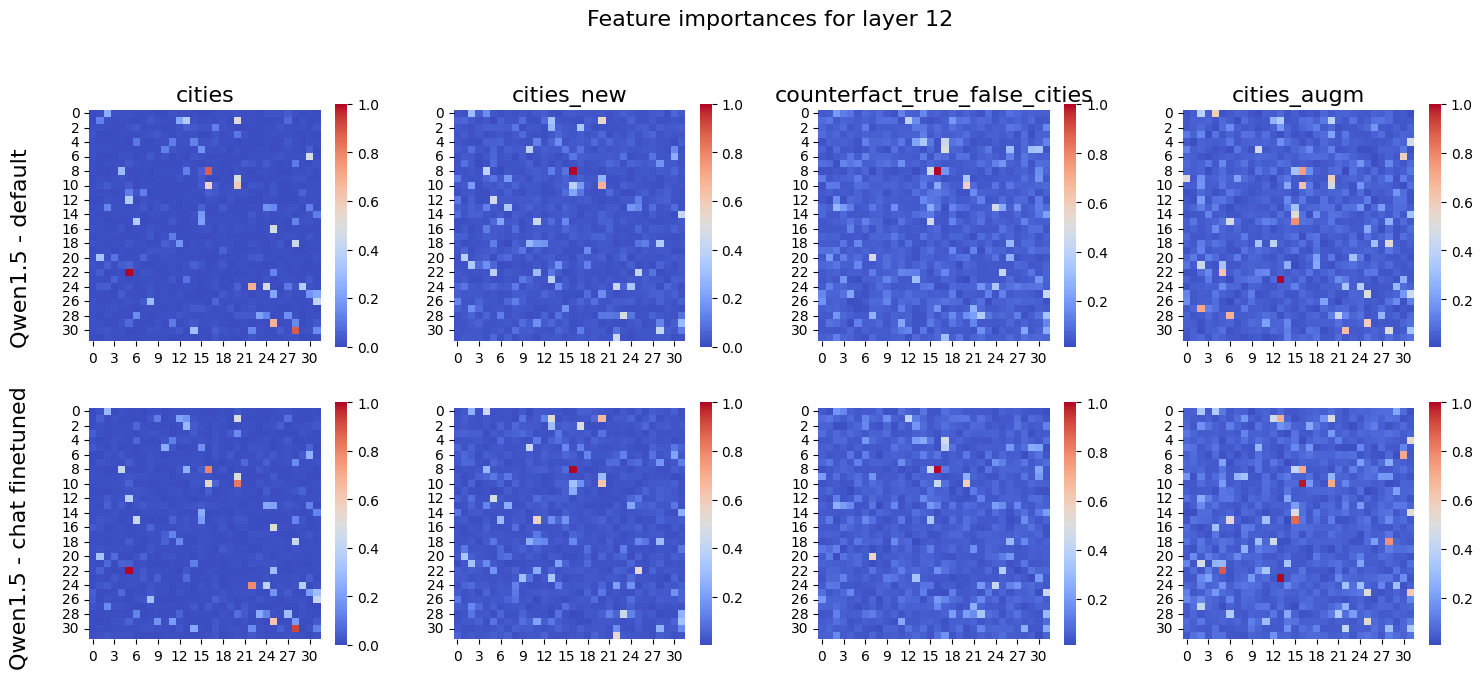

In [123]:
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt


def plot_heatmaps(importances, layers,datas):
    original_shape = (32, 32)
    importances_reshaped = []
    for i in range(len(importances)):
        importances_reshaped.append(np.array(importances[i]).reshape(original_shape))
    
    ncols = 4
    nrows = math.ceil(len(importances) / ncols)

    fig, axs = plt.subplots(2,len(importances)//2,figsize=(15,7))
    for i, ax in enumerate(axs.flat):
        if i < len(importances):
            ax = sns.heatmap(importances_reshaped[i], cmap='coolwarm', square=True, ax=ax)
            if i < 4 :
                ax.set_title(f'{datas[i]}',fontsize=16)
    fig.suptitle('Feature importances for layer 12',fontsize=16)
    #add another subpitle in the middle of the second row and make an angle of 90
    fig.text(0, 0.24, 'Qwen1.5 - chat finetuned', ha='center', va='center', rotation=90,fontsize=16)
    fig.text(0,0.64, 'Qwen1.5 - default', ha='center', va='center', rotation=90,fontsize=16)
    plt.tight_layout(pad=3.0)
    plt.show()


plot_heatmaps(importances,[12],["cities","cities_new","counterfact_true_false_cities","cities_augm"])